# Pset 3
 Muhammad Bashir

In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
# ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [131]:
# set paths to working directory 
path = '/Users/muhammadbashir/GitHub/MuhammadCourses/Ec240a/Problem Sets'
# load RPS_calorie_data.out data and read only columns Y0tc and X0te.
nlsy97ss = pd.read_csv('/Users/muhammadbashir/GitHub/MuhammadCourses/Ec240a/Ec240a_Fall2023/Data/NLSY97/nlsy97ss.csv')
nlsy97ss['LogEarn'] = np.log(nlsy97ss['avg_earn_2014_to_2018'])

In [235]:
def summary(data):
    # Create a table of summary statistics for avg_earn_2014_to_2018, LogEarn, hgc_ever and asvab for this sub-sample.
    summary_stats = data[['avg_earn_2014_to_2018', 'LogEarn', 'hgc_ever', 'asvab']].describe()
    summary_stats = summary_stats.rename(columns={
        'avg_earn_2014_to_2018': 'Average Earnings (2014-2018)',
        'LogEarn': 'Log of Earnings',
        'hgc_ever': 'Highest Grade Completed',
        'asvab': 'ASVAB Score'
    })
    summary_stats.loc['count'] = summary_stats.loc['count'].astype('int64')
    summary_stats = summary_stats.rename(index={'count':'Number of Observations','mean':'Mean','50%': 'Median', 'std': 'SD', 'min': 'Minimum', 'max': 'Maximum', '25%': 'Q1', '75%': 'Q3'})
    summary_stats.index.name = 'Statistic'
    summary_stats = summary_stats.round(2)
    print(summary_stats)

In [236]:
# do least square fit of LogEarn on hgc_ever and a constant. 
def LSQfit(data):
    X = data['hgc_ever']
    X = sm.add_constant(X)
    Y = data['LogEarn']
    model = sm.OLS(Y, X).fit(cov_type='HC3')
    return model

In [237]:
# LS fit of LogEarn on hgc_ever and asvab, constant
def LSQfit2(data):
    """Least squares fit of LogEarn on hgc_ever and asvab"""
    X = data[['hgc_ever', 'asvab']]
    X = sm.add_constant(X)
    Y = data['LogEarn']
    model = sm.OLS(Y, X).fit(cov_type='HC3')
    return model

In [238]:
# create variables for asvab-50, (asvab-50)*hgc_ever and then regression of logearn on hgc_ever, asvab-50, (asvab-50)*hgc_ever and a constant
def LSQfit3(data):
    """Least squares fit of LogEarn on hgc_ever, asvab, and interaction term"""
    nlsy97ss1['asvab_50'] = nlsy97ss1['asvab'] - 50
    nlsy97ss1['asvab_50_hgc_ever'] = nlsy97ss1['asvab_50'] * nlsy97ss1['hgc_ever']
    X = nlsy97ss1[['hgc_ever', 'asvab', 'asvab_50_hgc_ever']]
    X = sm.add_constant(X)
    Y = nlsy97ss1['LogEarn']
    model = sm.OLS(Y, X).fit(cov_type='HC3')
    return model

In [241]:
# plot coefficent estimates β0 + γ0 (asvab − 50) against asvab
def plot_cf(model,data):
    beta0 = model.params['hgc_ever']
    gamma0 = model.params['asvab_50_hgc_ever']
    data['asvab_50_hgc_ever_hat'] = beta0 + gamma0 * data['asvab_50']

    plt.scatter(data['asvab'], data['asvab_50_hgc_ever_hat'])
    plt.xlabel('ASVAB Score')
    plt.ylabel('β0 + γ0 (ASVAB - 50)')
    plt.title('β0 + γ0 (ASVAB - 50) against ASVAB')

In [222]:

def bayesian_bootstrap(data, num_bootstraps):
    """
    Perform Bayesian bootstrap to estimate the distribution of OLS coefficients.

    Parameters:
    - Y: 1D array-like, dependent variable.
    - X: 2D array-like, independent variables (including a constant if needed).
    - num_bootstraps: int, number of bootstrap samples.

    Returns:
    - beta_hat: NumPy array of shape (num_bootstraps, number_of_parameters),
                containing bootstrap estimates of the coefficients.
    """
    beta0 = []
    gamma0 = []
    N = len(data)
    
    for i in range(num_bootstraps):
        # Draw weights from Gamma(1,1) and normalize to sum to 1
        W = np.random.gamma(1,1,N)
        W = np.array(W)/sum(W)
        # create variables for asvab-50, (asvab-50)*hgc_ever and then regression of logearn on hgc_ever, asvab-50, (asvab-50)*hgc_ever and a constant
        X = data[['hgc_ever', 'asvab', 'asvab_50_hgc_ever']]
        X = sm.add_constant(X)
        Y = data['LogEarn']
        model = sm.WLS(Y, X, weights=W).fit(cov_type='HC3')       
        # Append the parameter estimates as a dictionary with variable names beta0 = model.params['hgc_ever']
        beta0.append(model.params['hgc_ever'])
        gamma0.append(model.params['asvab_50_hgc_ever'])
    
    return beta0, gamma0


In [224]:
# use each iteration of beta0 and gamma0 to predict the value of β0 + γ0 (asvab − 50) for each observation in the sample
def predict_LB_UB(data,beta0,gamma0,num_bootstraps):
    """ Predict the 95% confidence interval for β0 + γ0 (asvab − 50)"""
    asvab_50_hgc_ever_hat = np.array([b0 + g0 * nlsy97ss1['asvab_50'] for b0, g0 in zip(beta0, gamma0)])
    upper_i = int(np.floor(num_bootstraps * .025))
    lower_i = int(np.floor(num_bootstraps * .975))
    lower_bound = []
    upper_bound = []
    for i in range(len(nlsy97ss1['asvab_50'])):
        level_i_prediction = asvab_50_hgc_ever_hat[:, i]
        # sort the predictions
        level_i_prediction.sort()
        # get the 95% confidence interval
        lower_bound.append(level_i_prediction[lower_i])
        upper_bound.append(level_i_prediction[upper_i])

    nlsy97ss1['asvab_LB'] = lower_bound
    nlsy97ss1['asvab_UB'] = upper_bound

In [225]:
# plot the 95% confidence interval for β0 + γ0 (asvab − 50) against asvab. Sort the data by asvab before plotting.
def plot_CI(data):    
    data = data.sort_values(by='asvab')
    plt.scatter(data['asvab'], data['asvab_50_hgc_ever_hat'], color='blue', s=10)
    plt.plot(data['asvab'], data['asvab_LB'], color='red')
    plt.plot(data['asvab'], data['asvab_UB'], color='red')
    plt.xlabel('ASVAB Score')
    plt.ylabel('β0 + γ0 (ASVAB - 50)')
    plt.title('β0 + γ0 (ASVAB - 50) against ASVAB')
    plt.legend(['Point Estimate from OLS','Bayesian 95% CI'])
    plt.show()

## Using First subseting of data as in the question

                        Average Earnings (2014-2018)  Log of Earnings  \
Statistic                                                               
Number of Observations                       1606.00          1606.00   
Mean                                        75821.77            10.93   
SD                                          59827.90             0.91   
Minimum                                        58.45             4.07   
Q1                                          38395.24            10.56   
Median                                      61895.37            11.03   
Q3                                          94180.04            11.45   
Maximum                                    383978.89            12.86   

                        Highest Grade Completed  ASVAB Score  
Statistic                                                     
Number of Observations                  1606.00      1606.00  
Mean                                      14.35        56.95  
SD               

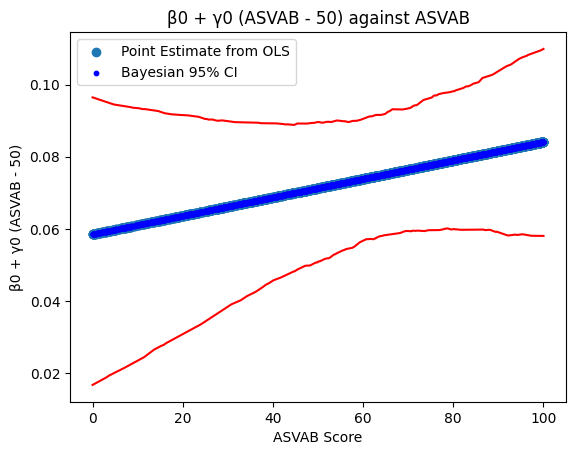

In [243]:
# subset to non-black,non-hispanic, non-female respondents with positive earings in 2014-2018
nlsy97ss1 = nlsy97ss[(nlsy97ss['black'] == 0) & (nlsy97ss['hispanic'] == 0) & (nlsy97ss['female'] == 0) & (nlsy97ss['avg_earn_2014_to_2018'] > 0)]
# summary statistics
summary(nlsy97ss1)
# LSQfit
Lsq1 = LSQfit(nlsy97ss1)
print("OLS Regression 1")
print(Lsq1.summary())
# LSQfit2
lsq2 = LSQfit2(nlsy97ss1)
print("OLS Regression 2")
print(lsq2.summary())
# LSQfit3
lsq3 = LSQfit3(nlsy97ss1)
print("OLS Regression 3")
print(lsq3.summary())
# plot coefficent estimates β0 + γ0 (asvab − 50) against asvab
plot_cf(lsq3,nlsy97ss1)
# Bayesian Bootstrap
num_bootstraps=1000
[beta0, gamma0]= bayesian_bootstrap(nlsy97ss1, num_bootstraps)
predict_LB_UB(nlsy97ss1,beta0,gamma0,num_bootstraps)
plot_CI(nlsy97ss1)

2. Compute the least squares fit of LogEarn onto a constant and hgc_ever. Report the point estimate on
the schooling variable as well as its heteroscedastic robust asymptotic standard error (you may use the
StatsModels implementation of OLS to do this; later in the course we will construct our own program
for these calculations).

The point estimate on schooling variable is 0.0973 and hetroskadestic robust standard error on this is 13.735. Note that schooling significantly predicts eanrings in this model and higher schooling leads to more earnings.

3. Compute the least squares fit of LogEarn on a constant, hgc_ever and asvab. Does the estimate
coefficient on hgc_ever change?

Yes the coefficient changes as the value is now lower which means some of variations in earnings that was being captured buy education before is due to asvab.

4. Estimate the parameters of the following linear regression model by the method of least squares
E∗[LogEarn| X] = α0 + β0hgc_ever + γ0hgc_ever × (asvab − 50) + δ0asvab
where X = (hgc_ever, hgc_ever × (asvab − 50), asvab)’.
(a) Provide a semi-elasticity interpretation of β0.
(b) Provide a semi-elasticity interpretation of β0 + γ0 (asvab − 50).

a. A one-year increase in schooling is associated with a 7.13% increase in earnings.
b. (β0 + γ0(asvab-50))*100 gives percentage change in earnings with one extra year of schooling for those with given level of asvab-50

5.  Construct a plot with the OLS estimate of β0 + γ0 (asvab − 50) on the y-axis and a grid of asvab
values on the x-axis.

6. Using the Bayes’ Bootstrap to approximate a posterior distribution for β0 + γ0 (asvab − 50) at each
value of asvab shown in your plot. Add (estimates of) the 0.025 and 0.975 quantiles, as well as the
mean, of the posterior distribution of β0 + γ0 (asvab − 50) to your plot.

The marginal impact increases as asvab score increases. But there is certain non-linearity into Bayesian confidence intervals. In general, for SEs in OLS, I had assume stracture of error term to estimate error but in this case I did not need any specfication of error term to get CI. This is great about Bayesian. However, we had to assume gamma weights and I am not sure how sensitive results are to that. 

## Using 2nd subseting where instead of white males I look at white females

                        Average Earnings (2014-2018)  Log of Earnings  \
Statistic                                                               
Number of Observations                       1449.00          1449.00   
Mean                                        50839.69            10.38   
SD                                          45172.37             1.18   
Minimum                                        81.54             4.40   
Q1                                          20749.86             9.94   
Median                                      42422.72            10.66   
Q3                                          66817.67            11.11   
Maximum                                    336241.07            12.73   

                        Highest Grade Completed  ASVAB Score  
Statistic                                                     
Number of Observations                  1449.00      1449.00  
Mean                                      15.18        59.36  
SD               

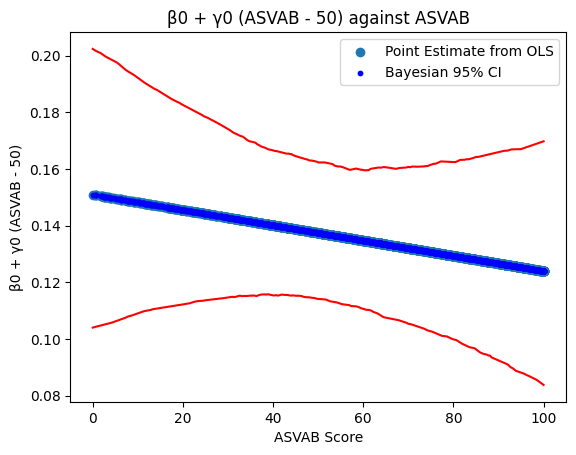

In [244]:
# subset to non-black,non-hispanic, females respondents with positive earings in 2014-2018
nlsy97ss1 = nlsy97ss[(nlsy97ss['black'] == 0) & (nlsy97ss['hispanic'] == 0) & (nlsy97ss['female'] == 1) & (nlsy97ss['avg_earn_2014_to_2018'] > 0)]
# summary statistics
summary(nlsy97ss1)
# LSQfit
Lsq1 = LSQfit(nlsy97ss1)
print("OLS Regression 1")
print(Lsq1.summary())
# LSQfit2
lsq2 = LSQfit2(nlsy97ss1)
print("OLS Regression 2")
print(lsq2.summary())
# LSQfit3
lsq3 = LSQfit3(nlsy97ss1)
print("OLS Regression 3")
print(lsq3.summary())
# plot coefficent estimates β0 + γ0 (asvab − 50) against asvab
plot_cf(lsq3,nlsy97ss1)
# Bayesian Bootstrap
num_bootstraps=1000
[beta0, gamma0]= bayesian_bootstrap(nlsy97ss1, num_bootstraps)
predict_LB_UB(nlsy97ss1,beta0,gamma0,num_bootstraps)
plot_CI(nlsy97ss1)